
# **Resources**

SentenceTransformers Documentation: https://www.sbert.net/

Pretrained Models for SentenceTransformers:https://www.sbert.net/docs/pretrained_models.html

Corpus: https://stackoverflow.com/questions/55619176/how-to-cluster-similar-sentences-using-bert

Youtube Tutorial about cnn for nlp:https://www.youtube.com/watch?v=wNBaNhvL4pg&t=1s

Wandb (weights & biases) documentation: https://wandb.ai/home


# **Install libraries**
**tweet-preprocessor:** we will use it after to clean our data

In [2]:
pip install tweet-preprocessor

**wandb:** we will use it to visualize the loss and the accuracy for each epoch


In [3]:
!pip install -U sentence-transformers

In [4]:
!pip install wandb

# **Import Librairies**

In [5]:
import pandas as pd
import re
import preprocessor as p

In [6]:
from keras.preprocessing import sequence
from keras.preprocessing import text

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, LSTM
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing import text
import wandb
from wandb.keras import WandbCallback

In [7]:
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# **Read the dataset**

In [51]:
df = pd.read_csv('topical_chat.csv')

df.head()

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1,Both are excellent technology they are helpfu...,Curious to dive deeper
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,1,Google provides online related services and p...,Curious to dive deeper
4,1,"Yeah, their services are good. I'm just not a...",Curious to dive deeper


# **Extract the sentiment possible values**
We extract the possible sentiment values to determine the number of clusters since each sentiment corresponds to a cluster.

In [52]:
unique_values = df['sentiment'].unique()

print(unique_values)


[' Curious to dive deeper' ' Happy' ' Neutral' ' Surprised' ' Disgusted'
 ' Sad' ' Fearful' ' Angry']


# **Transform sentiment labels to clusters numbers**

In [53]:
l=[]
for i in df['sentiment']:
  if i==' Curious to dive deeper':
     l.append(0)
  elif i==' Happy':
     l.append(1)
  elif i==' Neutral':
     l.append(2)
  elif i==' Surprised':
     l.append(3)
  elif i==' Disgusted':
     l.append(4)
  elif i==' Sad':
     l.append(5)
  elif i==' Fearful':
     l.append(6)
  elif i==' Angry':
     l.append(7)



# **Add cluster column in the Data Frame**

In [54]:
df['cluster']=l


In [55]:
a=np.bincount(df['cluster'])
a

array([80888, 29617, 41367, 30638,  1433,  2533,  1026,   876])

# **Cleaning the Data Frame**
**Preprocessor** library provides functionality to clean and preprocess tweets, possibly by removing URLs, usernames, hashtags, and other unwanted elements from the tweet text.

In [56]:
def clean_tweets(df):
    # punctuations we want to be replaced
    REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")
    REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?)|(-)|(/)|(:).")
    corpus = []
    for line in df:
        # clean data by sending it to tweet_processor
        sentence = p.clean(line)
        # remove puctuation
        sentence = REPLACE_NO_SPACE.sub("", sentence.lower()) # convert all tweets to lower cases
        sentence = REPLACE_WITH_SPACE.sub(" ", sentence)
        corpus.append(sentence)
    return corpus

We call the "clean_tweets" function and we add the values as a new column in the data frame to visualize the difference before and after cleaning.

In [57]:
df = df.groupby('cluster').head(1000)

#**Shuffle the Data**

In [58]:
from sklearn.utils import shuffle
df = shuffle(df)

In [16]:
df.head()

,conversation_id,message,sentiment,cluster
97313,4454,It is definitely a distraction that I did not...,Disgusted,4
291,14,"Never heard that one before, lol! There is a ...",Curious to dive deeper,0
2406,110,And re-edited the trench run scene to make it...,Happy,1
84840,3883,That it does.,Disgusted,4
17900,821,"I don't know about that, I do sympathize too ...",Sad,5


In [59]:
df['message_clean'] = clean_tweets(df['message'])
df.shape

(7876, 5)

# **Take 5000 from each cluster(to facilitate the process)**

In [18]:
# = df.groupby('cluster').head(5000)

# **Corpus list to manipulate**
We extract the values of 'message_clean' column in a list.

In [60]:
corpus = list(df['message_clean'])

# **True Values Extraction**
The extraction of true values(clusters numbers) in a list to use it later.

# **Wandb configuration**
The code demonstrates the usage of the "wandb" library for experiment tracking and configuration management.

In [20]:
'''wandb.init(reinit=True)
config = wandb.config

config.vocab_size = 1000
config.maxlen = 1000
config.embedding_dims = 50
config.filters = 32
config.kernel_size = 3
config.hidden_dims = 250
config.epochs = 10'''


'wandb.init(reinit=True)\nconfig = wandb.config\n\nconfig.vocab_size = 1000\nconfig.maxlen = 1000\nconfig.embedding_dims = 50\nconfig.filters = 32\nconfig.kernel_size = 3\nconfig.hidden_dims = 250\nconfig.epochs = 10'

# **Text preprocessing steps**
The code demonstrates text preprocessing steps using the Keras Tokenizer and sequence padding from TensorFlow.

These preprocessing steps are crucial for preparing text data to be used as input for machine learning models, as they convert the text into a numerical format that can be processed effectively. Additionally, sequence padding ensures that all sequences have the same length, allowing them to be inputted into models that require fixed-length inputs.

**`pad_sequences:`** This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence in the list.

Sequences that are shorter than num_timesteps are padded with value until they are num_timesteps long.

Sequences longer than num_timesteps are truncated so that they fit the desired length.

Documentation link :https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences

In [61]:
X_train = [str(sample) for sample in list(corpus[:7100])]
X_test = [str(sample) for sample in list(corpus[7101:])]

In [62]:
test=X_test

In [63]:
import numpy as np
X_train = embedder.encode(X_train)
#X_train=X_train /  np.linalg.norm(X_train, axis=1, keepdims=True)


In [64]:
import numpy as np
X_test = embedder.encode(X_test)
#X_test=X_test /  np.linalg.norm(X_test, axis=1, keepdims=True)

In [65]:
'''# Convert integers to strings
#df_train=df.groupby('cluster').head(788)
#df_test=df.groupby('cluster').head(88)
#X_train = [str(sample) for sample in list(df_train['message_clean'])]
#X_test = [str(sample) for sample in list(df_test['message_clean'])]
# Create and fit the tokenizer
tokenizer = text.Tokenizer(num_words=7000)

tokenizer.fit_on_texts(X_train + X_test)


# Convert sequences to numerical sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)'''

train_sequence_lengths = [len(sequence) for sequence in X_train]
test_sequence_lengths = [len(sequence) for sequence in X_test]

'''import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen=40)
X_test = pad_sequences(X_test, maxlen=40)
vocab_size = len(tokenizer.word_index) + 1'''


'import tensorflow\nfrom tensorflow.keras.preprocessing.sequence import pad_sequences\n\nX_train = pad_sequences(X_train, maxlen=40)\nX_test = pad_sequences(X_test, maxlen=40)\nvocab_size = len(tokenizer.word_index) + 1'

In [66]:
print("Train Sequence Lengths:")
print("  Min:", min(train_sequence_lengths))
print("  Max:", max(train_sequence_lengths))
print("  Average:", sum(train_sequence_lengths) / len(train_sequence_lengths))
print()
print("Test Sequence Lengths:")
print("  Min:", min(test_sequence_lengths))
print("  Max:", max(test_sequence_lengths))
print("  Average:", sum(test_sequence_lengths) / len(test_sequence_lengths))

Train Sequence Lengths:
  Min: 384
  Max: 384
  Average: 384.0

Test Sequence Lengths:
  Min: 384
  Max: 384
  Average: 384.0


# **Extracting y_train and y_test**
Converting the trueValues list into NumPy arrays, you can leverage the numerical processing capabilities provided by NumPy and perform various operations on the label data, such as calculations, slicing, or compatibility with certain machine learning algorithms that require NumPy arrays as input.

In [67]:
trueValues=df['cluster']
y_train=np.array(trueValues[:7100])
y_test=np.array(trueValues[7101:])

In [28]:
y_test[:10]

array([5, 7, 3, 4, 6, 2, 3, 3, 4, 6])

In [29]:
b=np.bincount(y_train)
b

array([903, 904, 908, 908, 890, 899, 898, 790])

In [30]:
b=np.bincount(y_test)
b

array([ 97,  96,  91,  92, 110, 101, 102,  86])

# **CNN Layers**
The code defines and trains a sequential model for text classification using the Keras library. The model architecture consists of an embedding layer, a convolutional layer, a global max pooling layer, and two dense layers. The model is compiled with binary cross-entropy loss, the Adam optimizer, and accuracy as the evaluation metric. It is trained on the training data (X_train and y_train) for a specified number of epochs. The validation data (X_test and y_test) is used to evaluate the model's performance during training. The Weights and Biases library is integrated for experiment tracking and visualization using the WandbCallback().

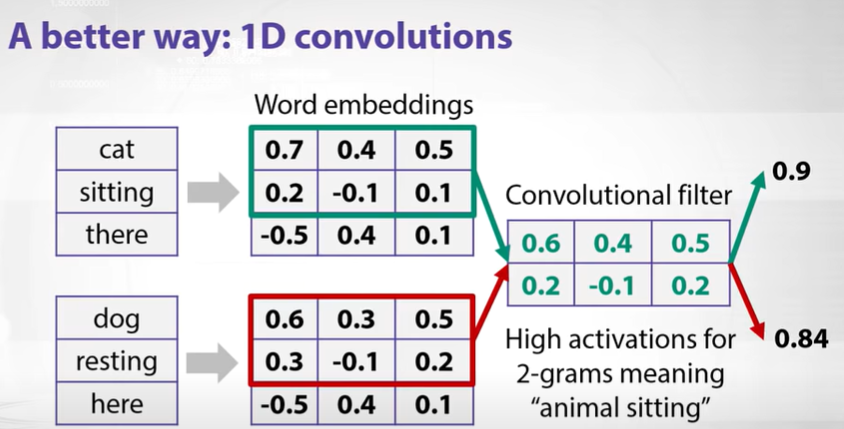

1. **For embedding layer:**

> **input_dim (vocab_size):** Size of the vocabulary:which represents the total number of unique words in your text corpus. In this case, the vocabulary size is set to 15,000, meaning that the model will consider 15,000 most frequent words in the corpus. Words outside this range will be treated as out-of-vocabulary (OOV) tokens.






> **output_dim :** This parameter represents the dimensionality of the word embeddings. Word embeddings are dense vector representations of words in a continuous vector space. Each word in the vocabulary will be represented by a vector of length 64 in this case. The choice of dimensionality depends on factors like the size of the dataset and the complexity of the language being modeled.

> **input_length:** This parameter specifies the length of the input sequences that the embedding layer will receive. In this case, the input sequences are expected to have a length of 1000. If a sequence is longer, it may be truncated, and if it is shorter, it may be padded with zeros. The choice of this value depends on the specific task and the typical length of the input data you are working with.



2.  **Conv1D layer**:


> **Number of filters (filters)**:
More filters allow the layer to capture a larger variety of patterns and features but also increase the computational complexity.
For smaller datasets or simpler tasks, you may start with a smaller number of filters (e.g., 32) and gradually increase it if necessary.
For larger datasets or complex tasks, you can experiment with larger numbers of filters (e.g., 64, 128, or more) to extract more intricate features.

> **Kernel size (kernel_size):**
The kernel size defines the size of the sliding window that moves across the input data.
Smaller kernel sizes capture local, fine-grained features, while larger kernel sizes capture more global, coarse-grained features.
Common kernel sizes are usually odd numbers (e.g., 3, 5, 7) to ensure a symmetric receptive field.

> **Activation function (activation):**
The activation function introduces non-linearity to the output of the Conv1D layer.
ReLU (Rectified Linear Unit) is a popular choice due to its simplicity and effectiveness in capturing non-linearities. It sets negative values to zero and keeps positive values unchanged.
Other activation functions like sigmoid or tanh may be suitable for specific cases, depending on the desired behavior of the network.
ReLU is often a good starting point and can be adjusted based on your model's performance.

**3. Dense layer:**

The choice of the dense layers and activation function in your sequential model depends on the specific requirements and characteristics of your clustering task. Here are some considerations to help you make informed decisions:

> **Dense layer(s):**
The number of dense layers and their size should be determined based on the complexity of your task and the expressiveness needed in the model.
For simpler tasks or smaller datasets, a single dense layer may be sufficient. As the complexity of the task increases, you can experiment with adding more dense layers.
You can start with a reasonable number of units (e.g., 8, 16, 32) and adjust it based on the performance of your model.
Adding more dense layers can increase the model's capacity to learn complex patterns but also increases the risk of overfitting. Regularization techniques like dropout or L2 regularization can be employed to mitigate overfitting.

> **Activation function:**
The choice of activation function depends on the nature of your clustering task and the desired behavior of the network.
For multi-class classification tasks like clustering, the softmax activation function is commonly used in the output layer. It converts the model's raw output into probability distributions over the classes.
For the hidden dense layers, the choice of activation function can vary.
ReLU (Rectified Linear Unit) is a popular choice due to its simplicity and ability to capture non-linearities. It sets negative values to zero and keeps positive values unchanged.
Other activation functions like sigmoid or tanh can also be considered, depending on the behavior you want the network to exhibit.
Experimentation with different activation functions is recommended to determine the best fit for your specific task.

In [31]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.optimizers import Adam

In [32]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define your model
model = Sequential()
model.add(Embedding(200, 32, input_length=384))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(X_train, y_train, batch_size=100, epochs=30, validation_data=(X_test, y_test))



Epoch 1/30
71/71 [==============================] - 45s 625ms/step - loss: 2.0812 - accuracy: 0.1192 - val_loss: 2.0775 - val_accuracy: 0.1239
Epoch 2/30
71/71 [==============================] - 44s 614ms/step - loss: 2.0797 - accuracy: 0.1239 - val_loss: 2.0773 - val_accuracy: 0.1226
Epoch 3/30
71/71 [==============================] - 44s 615ms/step - loss: 2.0795 - accuracy: 0.1231 - val_loss: 2.0774 - val_accuracy: 0.1290
Epoch 4/30
71/71 [==============================] - 43s 612ms/step - loss: 2.0791 - accuracy: 0.1283 - val_loss: 2.0764 - val_accuracy: 0.1226
Epoch 5/30
71/71 [==============================] - 44s 624ms/step - loss: 2.0794 - accuracy: 0.1235 - val_loss: 2.0776 - val_accuracy: 0.1329
Epoch 6/30
71/71 [==============================] - 43s 606ms/step - loss: 2.0789 - accuracy: 0.1279 - val_loss: 2.0768 - val_accuracy: 0.1239
Epoch 7/30
71/71 [==============================] - 44s 614ms/step - loss: 2.0796 - accuracy: 0.1246 - val_loss: 2.0771 - val_accuracy: 0.1226

# **Predict results**
`y_pred = model.predict(X_test)` predicts the output labels for the test data X_test using the trained model.

By executing this code, you obtain the predicted labels or probabilities for the test data X_test using the trained model. These predictions can be used for evaluation, or any other relevant post-processing tasks.

In [34]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
y_pred = model.predict(X_test)

 3/25 [==>...........................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


25/25 [==============================] - 1s 21ms/step


In [35]:
y_pred = np.argmax(y_pred, axis=1)

In [36]:
predict = list(y_pred)
unique_predict = list(set(predict))
unique_predict

[2]

In [37]:
import pandas as pd

predict = list(y_pred)
unique_predict = list(set(predict))  # Get unique cluster indices
cluster_labels = [' Curious to dive deeper', ' Happy', ' Neutral', ' Surprised' ,' Disgusted',
 ' Sad' ,' Fearful' ,' Angry']  # Corresponding cluster labels

true=y_test
unique_test=list(set(true))

# Create the mapping dictionary
clusters_pred = dict(zip(unique_predict, cluster_labels))
clusters_test = dict(zip(unique_test, cluster_labels))
# Create the DataFrame
df = pd.DataFrame({'sentence': test, 'y_pred': predict, 'true_value': true})
# Map the numerical values in the 'Cluster' column to their corresponding strings
df['y_pred'] = df['y_pred'].map(clusters_pred)
df['true_value'] = df['true_value'].map(clusters_test)

# Print the DataFrame
df.head(20)



,sentence,y_pred,true_value
0,it is always sad when you lose one of your fur...,Curious to dive deeper,Sad
1,it sounds like thats where it belongs like a t...,Curious to dive deeper,Angry
2,i have yes they are having another baby,Curious to dive deeper,Surprised
3,true the waiters seem overly enthusiastic thou...,Curious to dive deeper,Disgusted
4,i like comedy but as you said good comedy it t...,Curious to dive deeper,Fearful
5,i could only imagine i wonder where they keep ...,Curious to dive deeper,Neutral
6,i never knew that i wonder whose i know i hear...,Curious to dive deeper,Surprised
7,many are adopting the kids because they want t...,Curious to dive deeper,Surprised
8,i think you are right with tv news being the t...,Curious to dive deeper,Disgusted
9,i think everything should have a fear of snake...,Curious to dive deeper,Fearful


In [ ]:
X_test

In [39]:

y_pred

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

# **F_measure (F1-score)**
 F-measure score, which is a metric commonly used to evaluate the clustering performance. It quantifies the trade-off between precision and recall, providing a single value that represents the overall clustering quality. The higher the F-measure score, the better the clustering performance.

In [ ]:
from sklearn.metrics import f1_score

# Calculate F-measure
f_measure = f1_score(y_test, y_pred, average='weighted')

print("F-measure:", f_measure)

# **Accuracy**
**'get_accuracy**' that calculates the accuracy score between the predicted values (predictions) and the true values (Y). It returns the accuracy score, which represents the proportion of correct predictions out of the total number of predictions.

In [ ]:
from sklearn.metrics import accuracy_score
clustering_accuracy = accuracy_score(y_test, y_pred)

clustering_accuracy